# Прогнозирование оттока клиентов сети фитнес-центров

## Задача

Разработать стратегию взаимодействия с клиентами сети фитнес-центров: провести анализ и подготовить план действий по их удержанию.

## Описание данных

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- Churn — факт оттока в текущем месяце;
- Текущие поля в датасете:
    - Данные клиента за предыдущий до проверки факта оттока месяц:
        - gender — пол;
        - Near_Location — проживание или работа в районе, где находится фитнес-центр;
        - Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
        - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
        - Phone — наличие контактного телефона;
        - Age — возраст;
        - Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    - Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
    - Group_visits — факт посещения групповых занятий;
    - Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
    - Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
    - Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Оглавление

### [Шаг 1. Загрузка данных](#read_data)
### [Шаг 2. Исследовательский анализ данных](#eda)
### [Шаг 3. Построение модели прогнозирования оттока клиентов](#model)
### [Шаг 4. Кластеризация клиентов](#clusterization)
### [Шаг 5. Выводы и базовые рекомендации по работе с клиентами](#results)

## Ход работы

#### Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter('ignore')

## <a id='read_data'>Шаг 1. Загрузка данных</a>

In [2]:
def review_file(filename):
    '''
    Функция сохраняет данные в возвращаемую переменную
    и выводит необходимую информацию на экран.
    
    Аргументы:
        filename (str): путь к файлу.
    '''
    
    table = pd.read_csv(filename)
    
    print('\033[1m'
          + 'Общая информация о таблице:'
          + '\033[0m')
    print()
    table.info()
    print()
    
    print('\033[1m'
          + 'Первые 10 строк таблицы:'
          + '\033[0m')
    display(table.head(10))
        
    print('\033[1m' +
          'Количество пропусков в каждом столбце таблицы:'
          + '\033[0m')
    display(pd.DataFrame(table.isna().sum()))
    
    print('\033[1m'
          + f'Число дубликатов в таблице: {table.duplicated().sum()}'
          + '\033[0m')
    
    return table

In [3]:
gym_churn = review_file('/datasets/gym_churn.csv')

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB

Перв

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Количество пропусков в каждом столбце таблицы:


,0
gender,0
Near_Location,0
Partner,0
Promo_friends,0
Phone,0
Contract_period,0
Group_visits,0
Age,0
Avg_additional_charges_total,0
Month_to_end_contract,0


Число дубликатов в таблице: 0


#### Приведём тип данных столбца *Month_to_end_contract* к типу *int64*.

In [4]:
gym_churn['Month_to_end_contract'] = gym_churn['Month_to_end_contract'].astype('int64')

### Вывод

Датафрейм **gym_churn** состоит из 4 000  строк и 14 столбцов. Пропусков нет. Дубликаты отсутствуют.

Данные столбца *Month_to_end_contract* (типа *float64*), были приведены к типу *int64*. 

## <a id='eda'>Шаг 2. Исследовательский анализ данных</a>

#### Изучим датасет.

In [5]:
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Отсутствующих признаков в датасете нет. Подавляющее большинство посетителей фитнес-центров проживают или работают в районе, где он находится (84%), а также указали контактный телефон (90%). Около трети всех посетителей использовали промо-код от знакомого при оплате первого абонемента. 

#### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [6]:
gym_churn.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


#### Построим гистограммы плотностей распределений признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

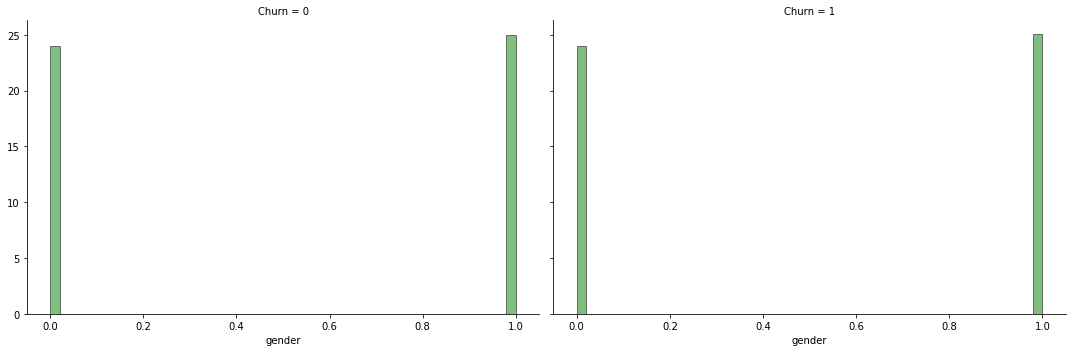

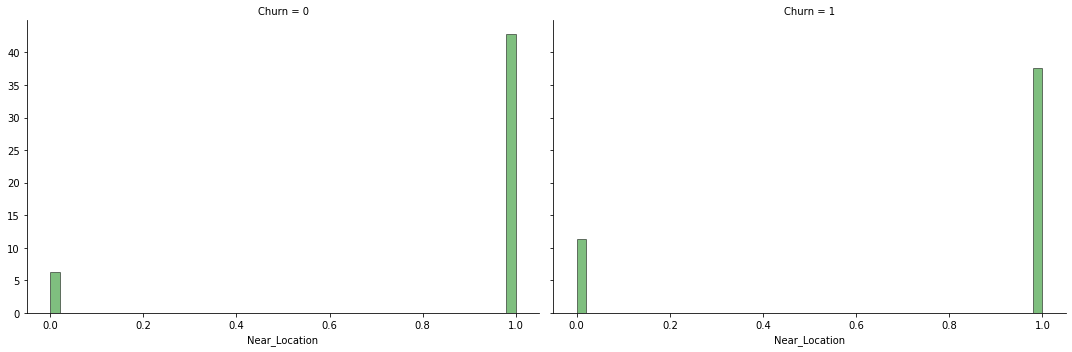

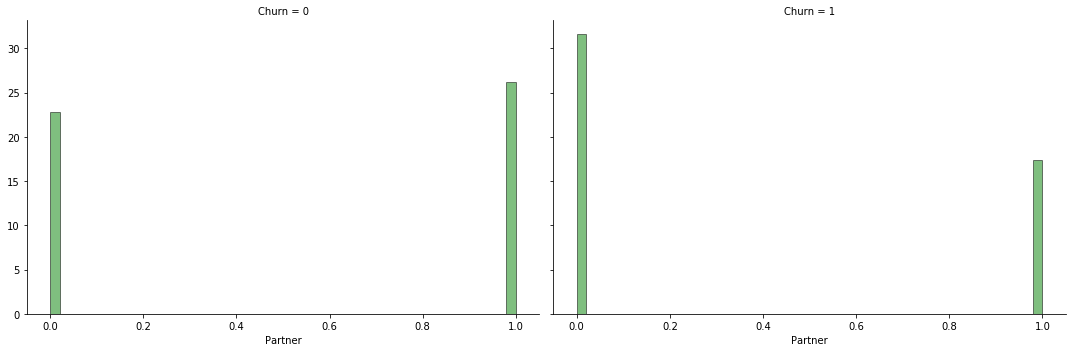

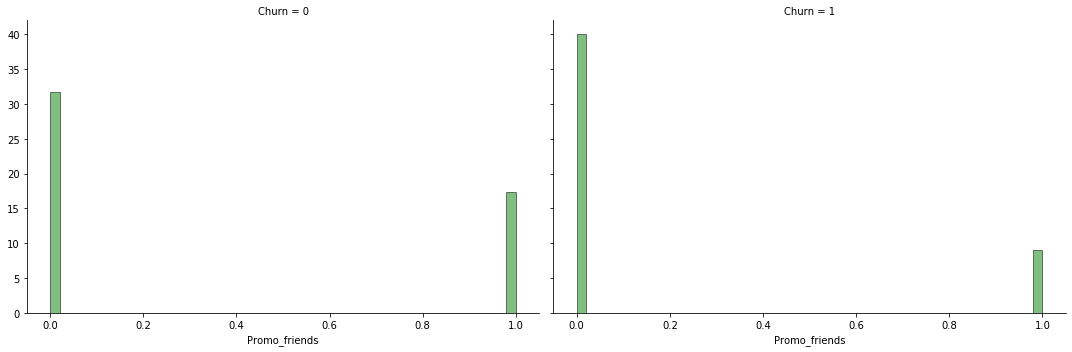

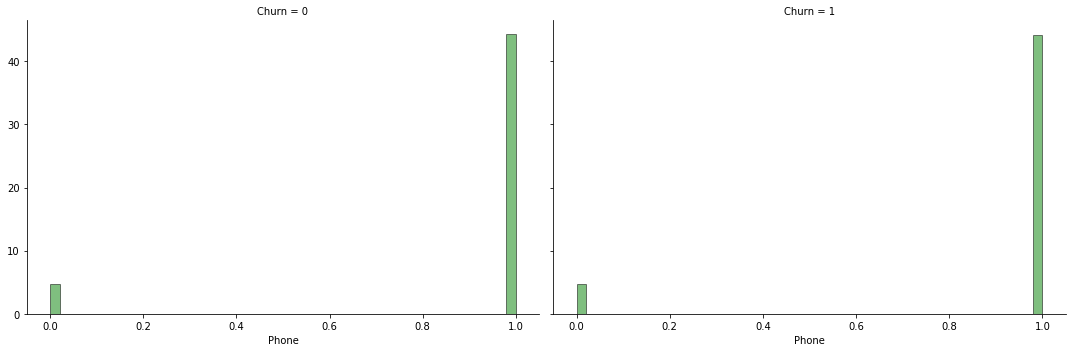

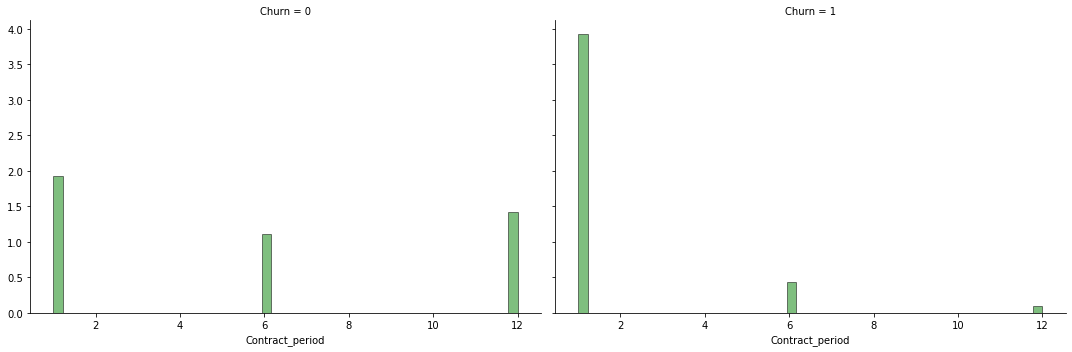

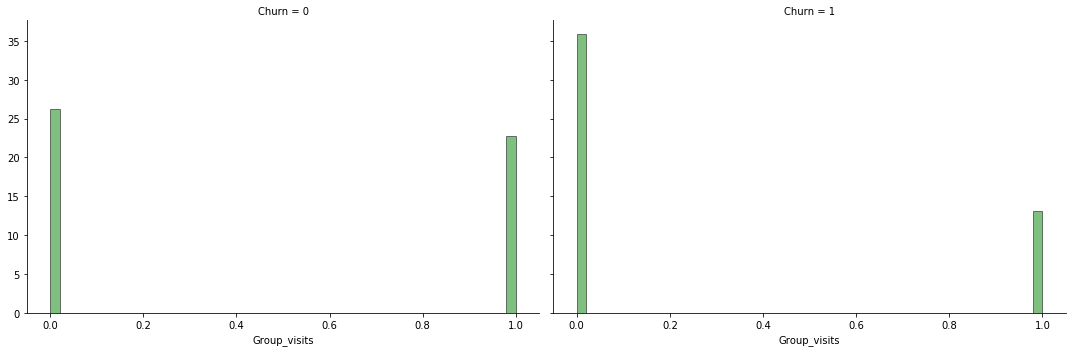

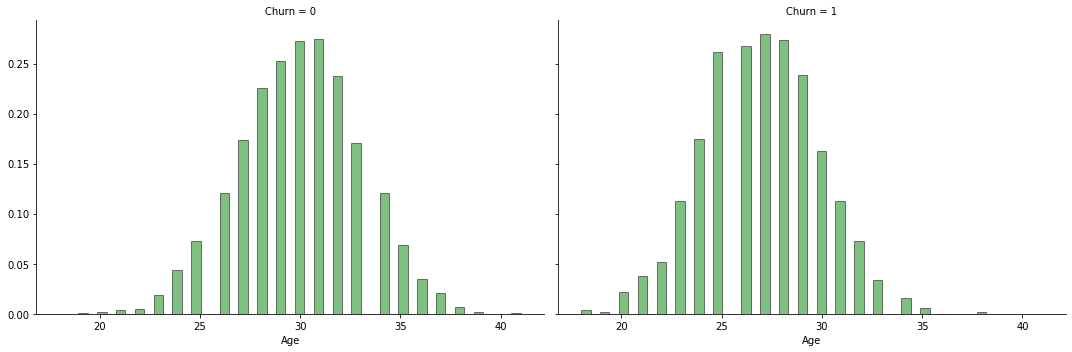

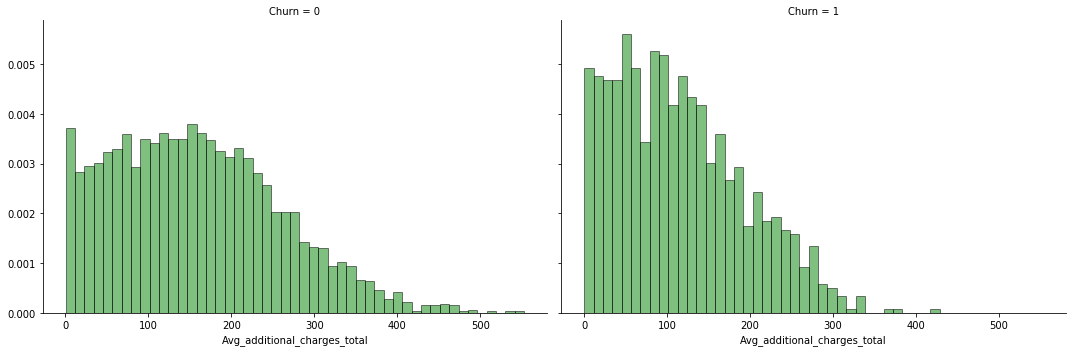

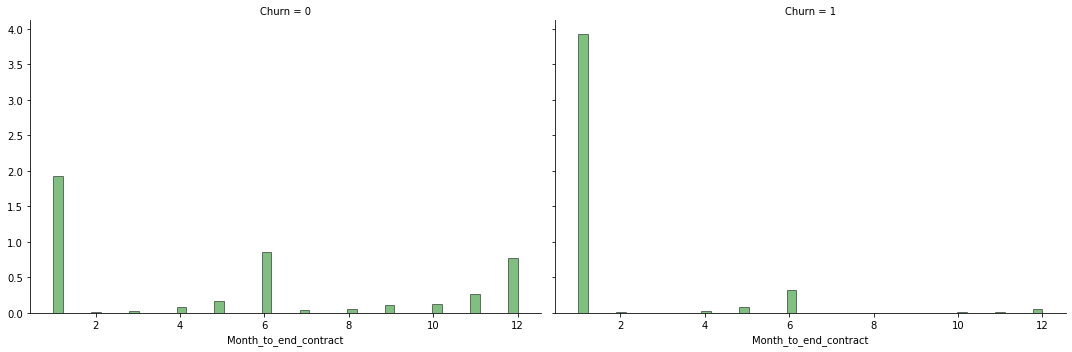

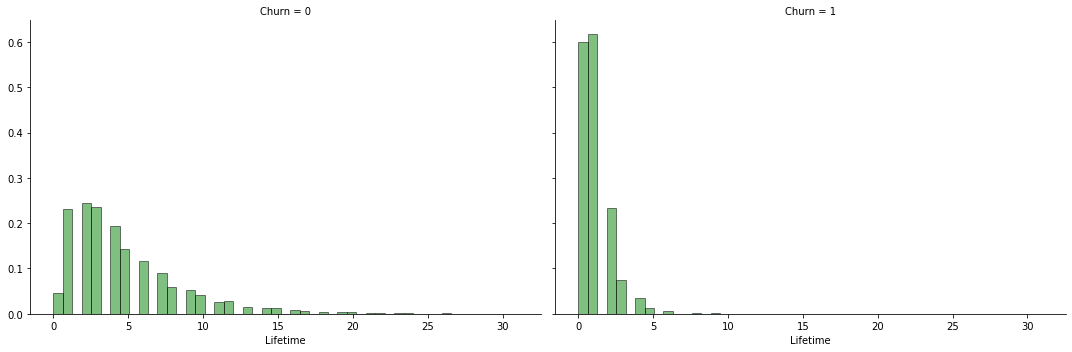

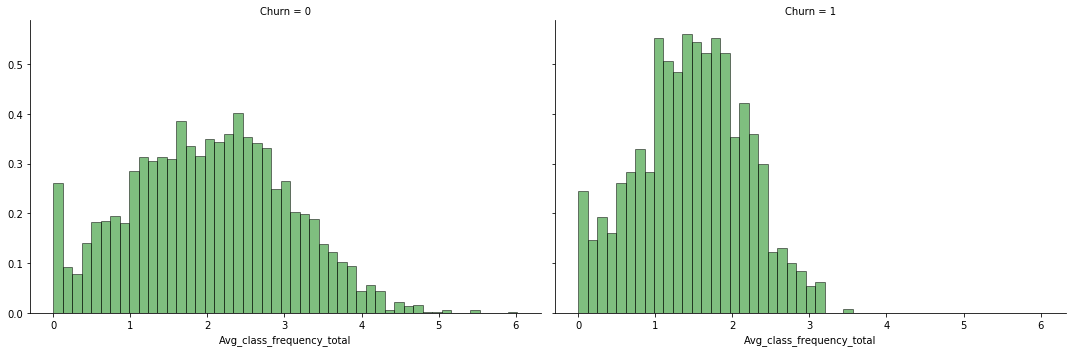

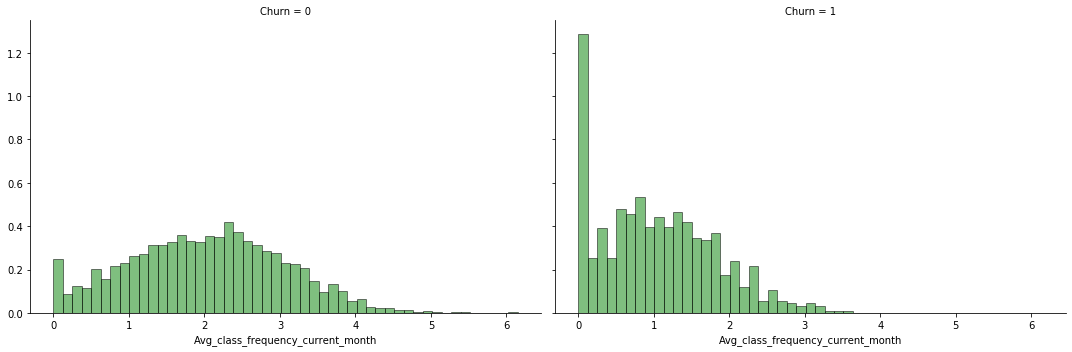

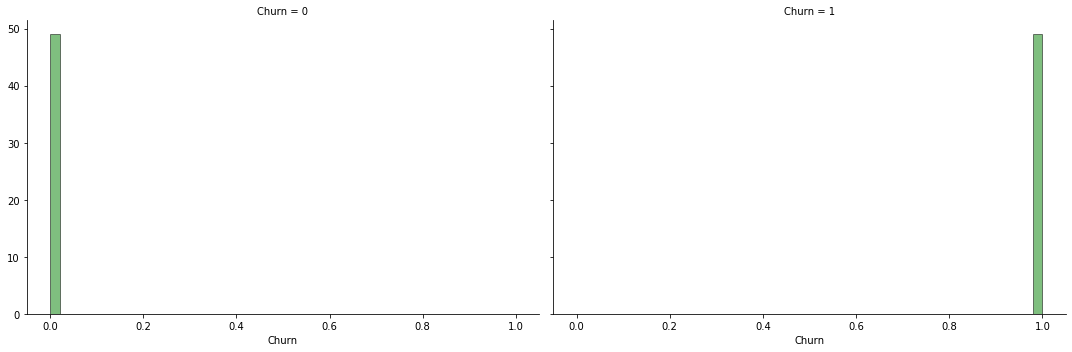

In [7]:
for feature in gym_churn.columns.to_list():
    bins_range = np.linspace(min(gym_churn[feature]), max(gym_churn[feature]))
    g = sns.FacetGrid(gym_churn, col='Churn', height=5, aspect=1.5)
    g.map(sns.distplot, feature, norm_hist=True, kde=False, bins=bins_range, color='green',
         hist_kws={'ec': 'black', 'alpha': 0.5})
    plt.show()

Сотрудники компании-партнёра покидают центр реже. 

Ушедшие клиенты отдают предпочтение месячному абонементу и, соответственно, чаще уходят в первый же месяц, в то время как среди оставшихся популярны все виды абонементов.

Покинувшие фитнес-центр клиенты редко посещают групповые занятия.

#### Построим матрицу корреляций и отобразим её.

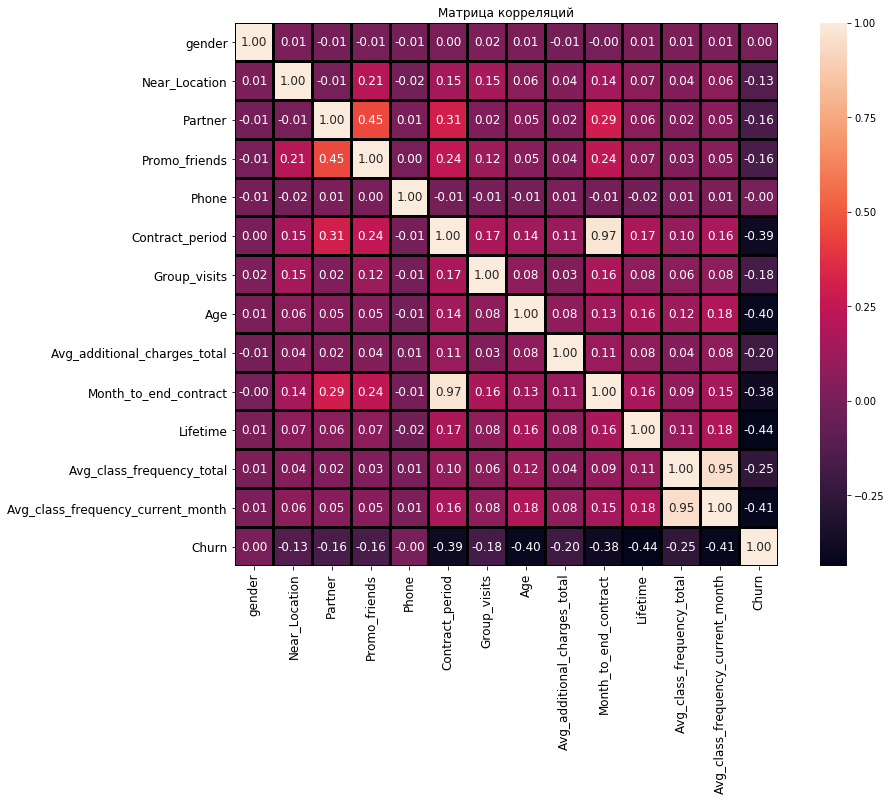

In [8]:
cm = gym_churn.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, square=True, fmt='.2f', linewidths=2, 
            linecolor='black', ax=ax, annot_kws={'size': 12})
ax.set_title('Матрица корреляций', fontsize=12)
plt.tick_params(labelsize=12)
plt.show()

Пары признаков *Month_to_end_contract* и *Contract_period*, а также *Avg_class_frequency_total* и *Avg_class_frequency_current_month* очень сильно коррелируют между собой. Между остальными признаками не наблюдается сильной попарной зависимости, в том числе и с целевым признаком *Churn*.

### Вывод

Сотрудники компании-партнёра покидают центр реже. 

Ушедшие клиенты отдают предпочтение месячному абонементу и, соответственно, чаще уходят в первый же месяц, в то время как среди оставшихся популярны все виды абонементов.

Покинувшие фитнес-центр клиенты редко посещают групповые занятия.

Пары признаков *Month_to_end_contract* и *Contract_period*, а также *Avg_class_frequency_total* и *Avg_class_frequency_current_month* очень сильно коррелируют между собой. Между остальными признаками не наблюдается сильной попарной зависимости, в том числе и с целевым признаком *Churn*.

## <a id='model'>Шаг 3. Построение модели прогнозирования оттока клиентов</a>

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

#### Разобьём данные на обучающую и валидационную выборку.

In [9]:
X = gym_churn.drop('Churn', axis=1)
y = gym_churn['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

#### Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.

In [10]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

#### Оценим метрики *accuracy*, *precision* и *recall* для обеих моделей на валидационной выборке и сравним по ним модели.

In [11]:
def print_all_metrics(y_true, y_pred, title='Метрики классификации:'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [12]:
print_all_metrics(
    y_test,
    lr_predictions,
    title='Метрики для модели логистической регрессии:',
)

print()

print_all_metrics(
    y_test,
    rf_predictions,
    title='Метрики для модели случайного леса:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


### Вывод

Построена модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Метрики для модели логистической регрессии:
- Accuracy: 0.93
- Precision: 0.86
- Recall: 0.83

Метрики для модели случайного леса:
- Accuracy: 0.92
- Precision: 0.84
- Recall: 0.82

Модель логистической регрессии показала себя немного лучше на основании метрик.

## <a id='clusterization'>Шаг 4. Кластеризация клиентов</a>

Проведём кластеризацию клиентов.

#### Стандартизируем данные.

In [13]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#### Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму.

In [14]:
linked = linkage(X_sc, method='ward') 

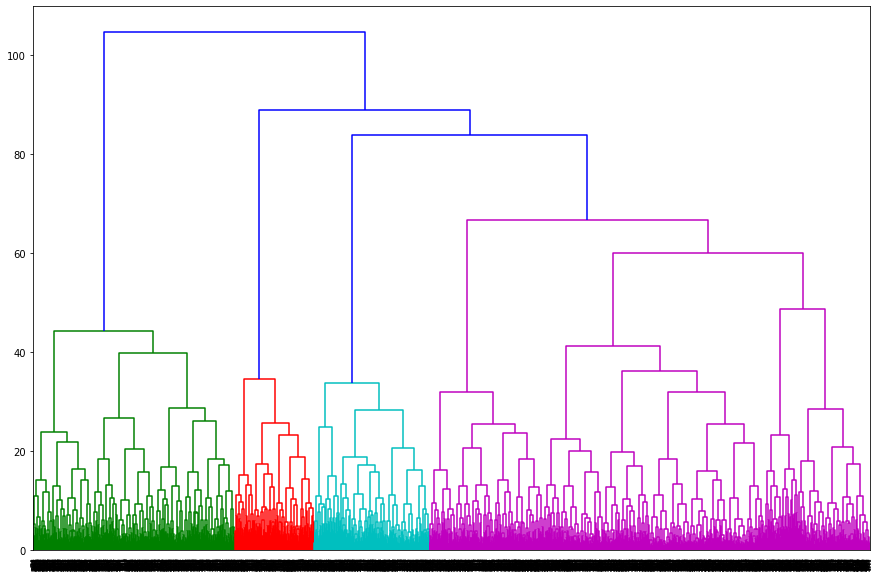

In [15]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике.

#### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [16]:
km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(X_sc)
gym_churn['cluster_km'] = labels

#### Посмотрим на средние значения признаков для кластеров.

In [17]:
gym_churn.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
1,0.486815,0.759297,0.381339,0.190669,1.0,1.899256,0.292765,28.048005,129.704525,1.805274,2.235294,1.204610,0.951590,0.559838
2,0.544939,0.861873,0.343425,0.205298,1.0,2.403027,0.447493,29.989593,157.358764,2.239357,4.704825,2.724796,2.711132,0.092715
3,0.503711,0.940631,0.777365,0.572356,1.0,10.697588,0.536178,29.912801,161.363032,9.768089,4.730056,1.983884,1.975592,0.029685


#### Построим распределения признаков для кластеров.

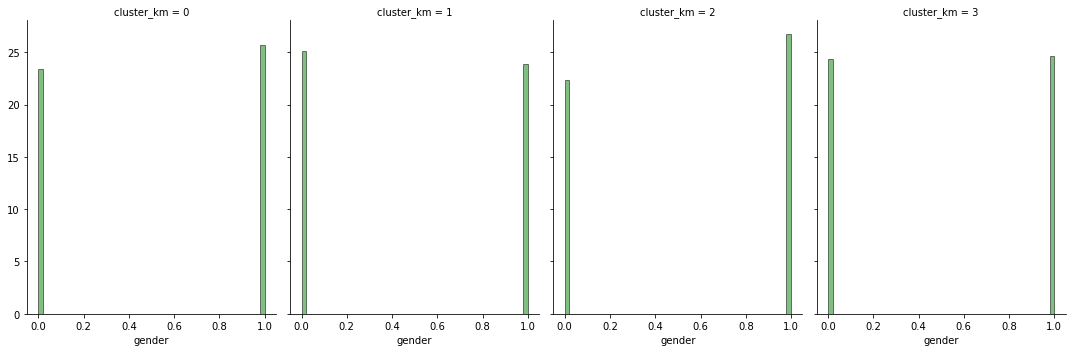

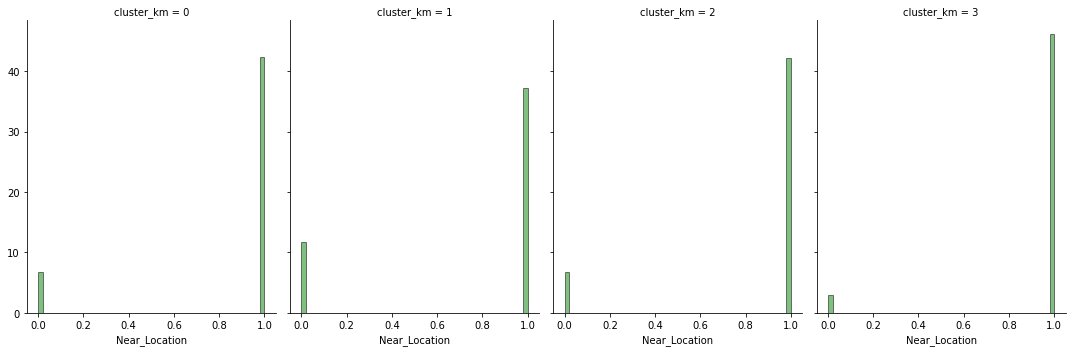

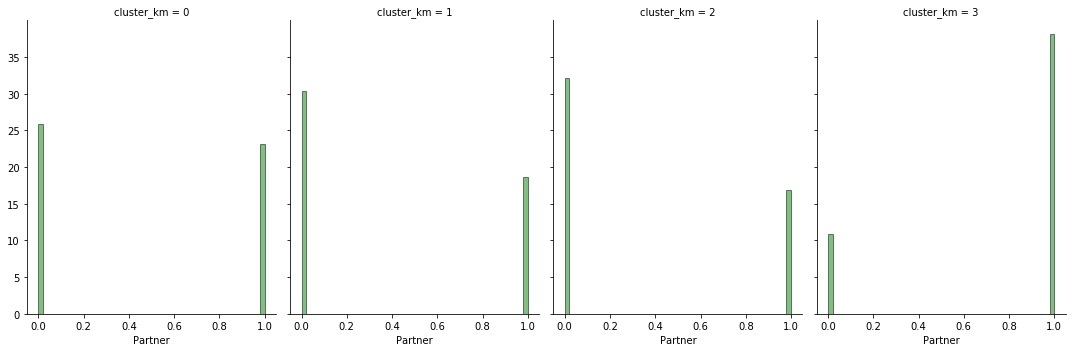

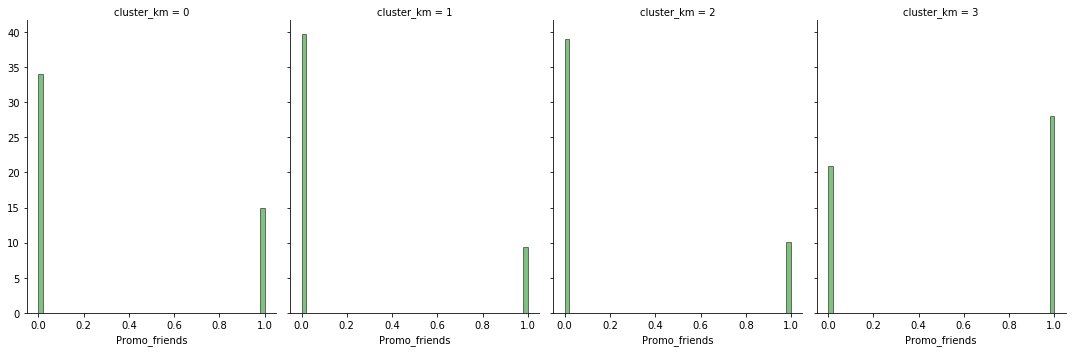

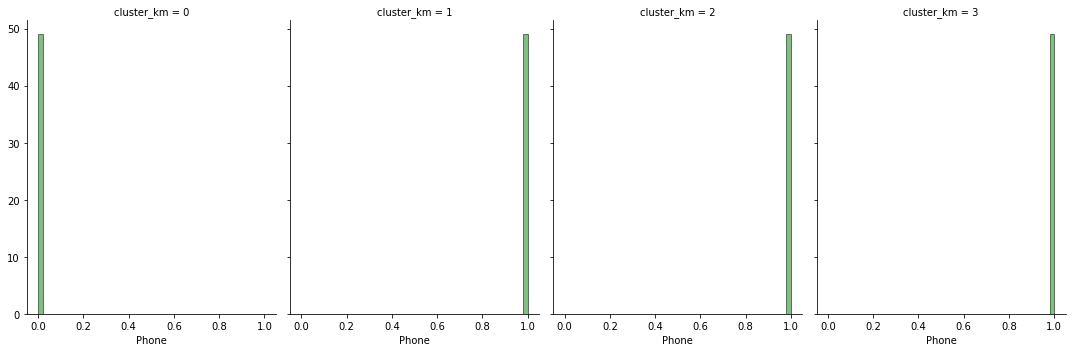

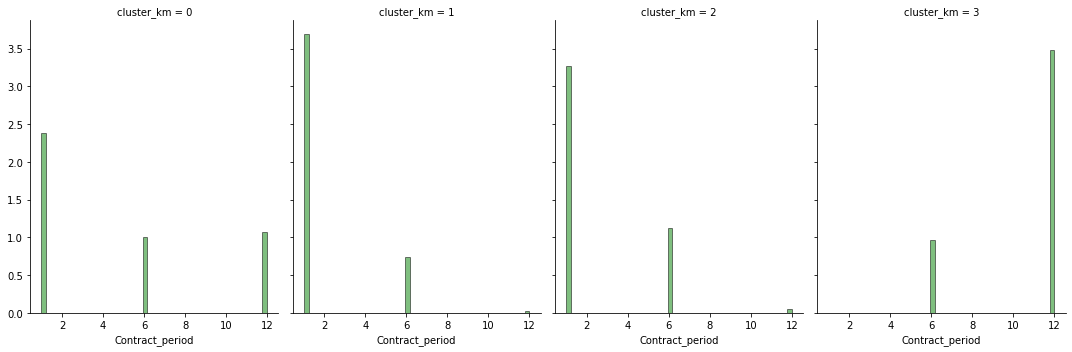

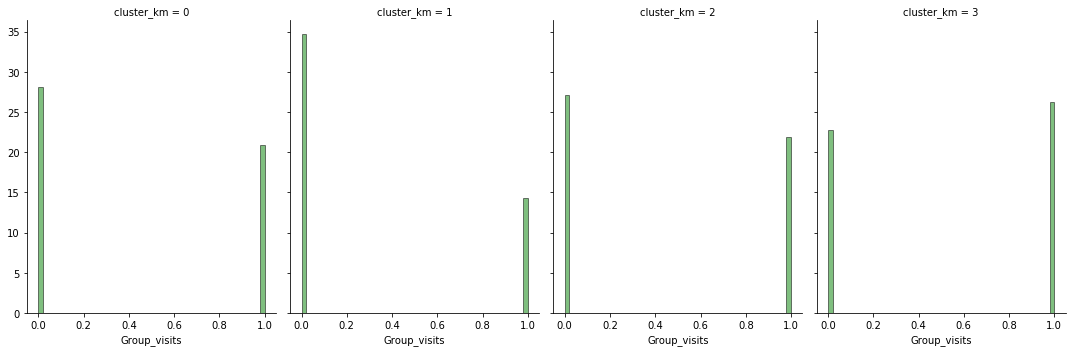

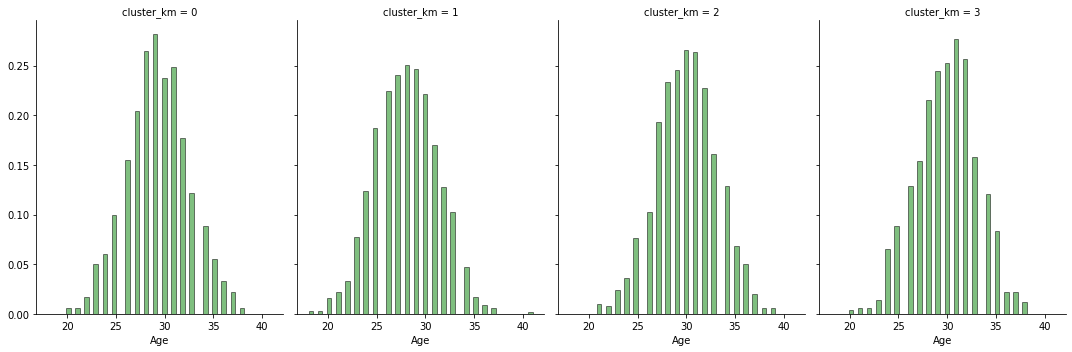

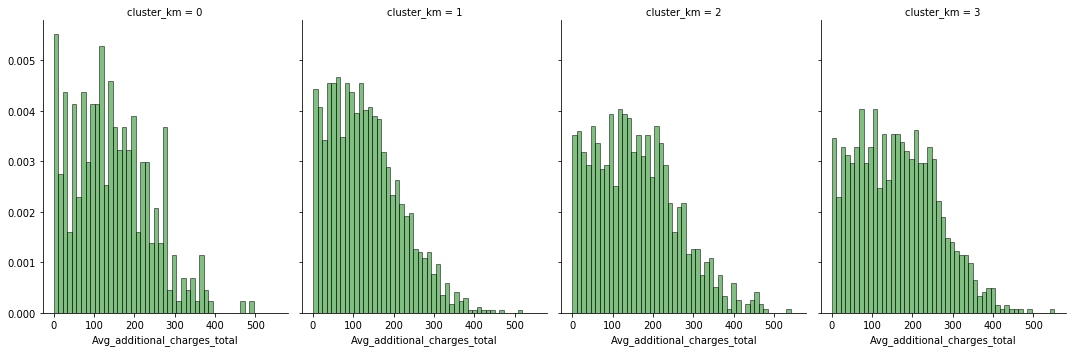

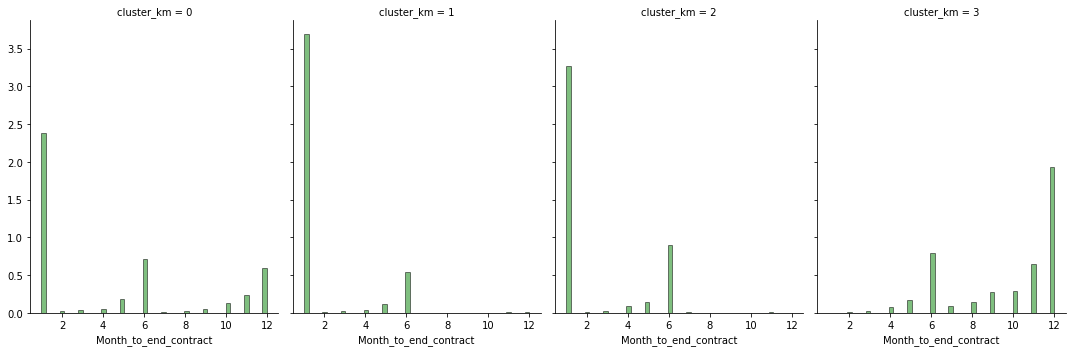

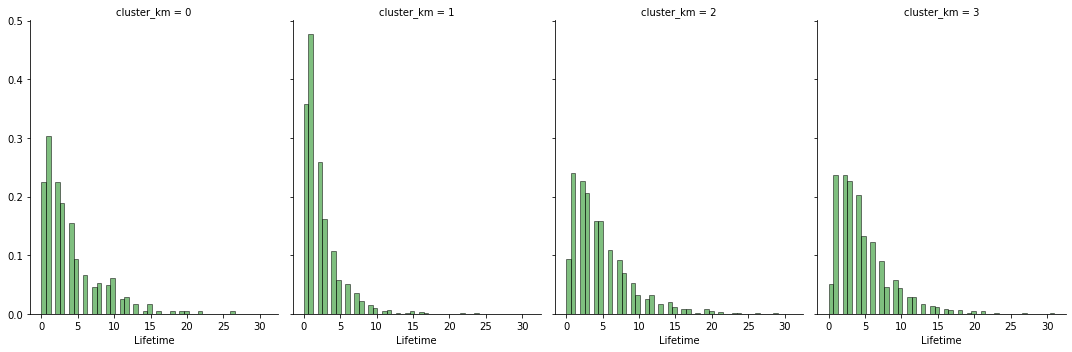

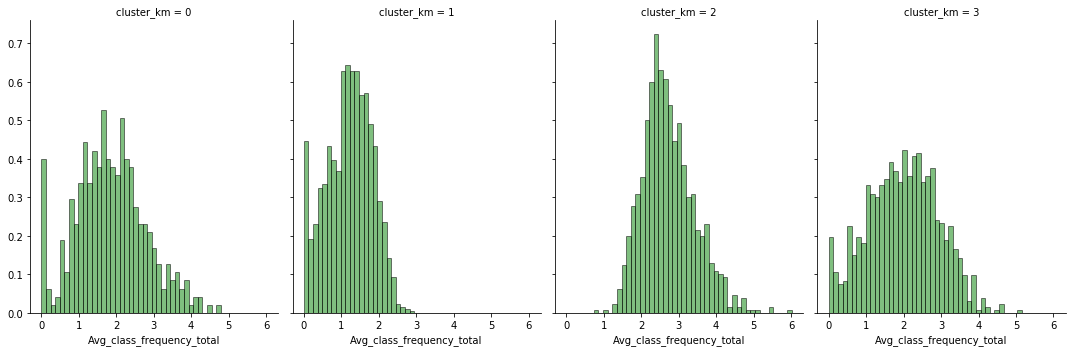

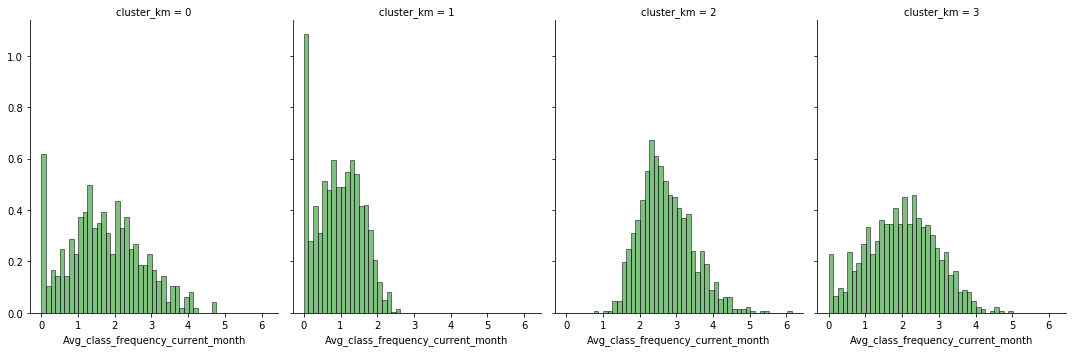

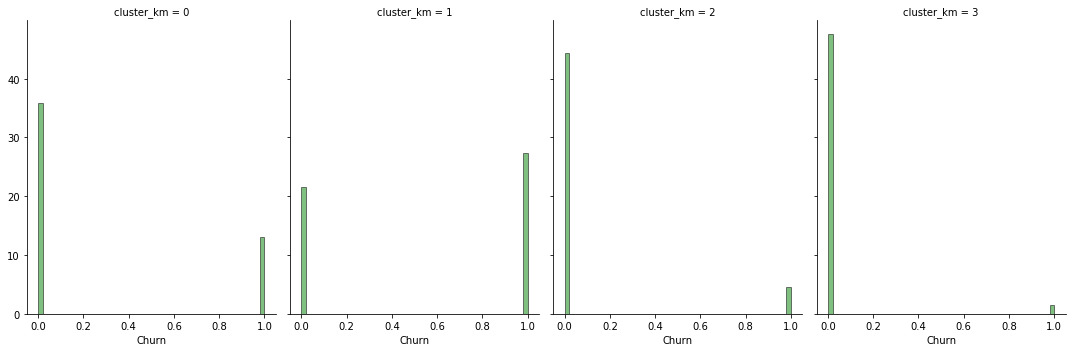

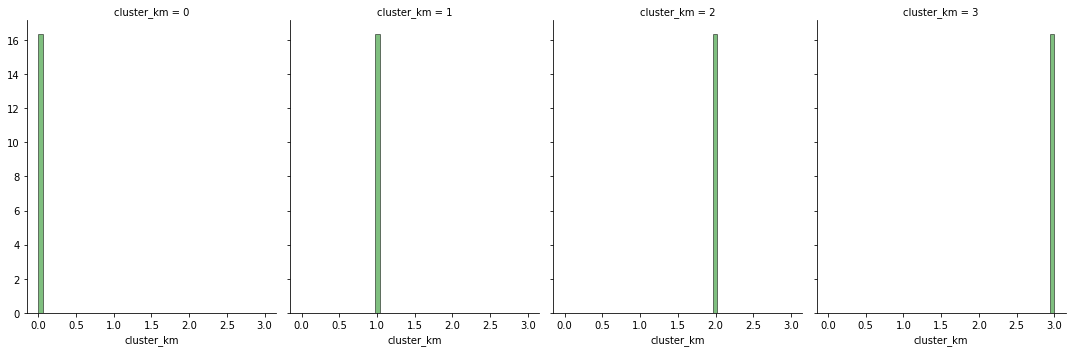

In [18]:
for feature in gym_churn.columns.to_list():
    bins_range = np.linspace(min(gym_churn[feature]), max(gym_churn[feature]))
    g = sns.FacetGrid(gym_churn, col='cluster_km', height=5, aspect=0.75)
    g.map(sns.distplot, feature, norm_hist=True, kde=False, bins=bins_range, color='green',
         hist_kws={'ec': 'black', 'alpha': 0.5})
    plt.show()

#### Портрет клиента из кластера 0:
1. Мужчина или женщина.
2. Живёт или работаёт, скорее, недалеко от фитнес-центров.
3. Примерно в равных долях является сотрудником компаний-партнёров клуба и не является таковым.
4. В 30% случаев использовал промо-код от знакомого при оплате первого абонемента.
5. **Не указал контактный номер телефона.**
6. Чаще имеет месячный абонемент, немного реже (и примерно в равных долях) — полугодовой или годовой. Среднее значение — 4.5 месяца.
7. Соответственно срок до окончания текущего действующего абонемента чаще составляет 1 месяц, но в среднем — те же 4.5 месяца.
8. Немного чаще не посещает групповые занятия, нежели посещает их.
9. Ему примерно 30 лет.
10. Тратит в среднем 145 у.е. на другие услуги фитнес-центра.
11. С момента его первого обращения в фитнес центр прошло около 4 месяцев.
12. Посещает фитнес-центр в среднем почти 2 раза в неделю с начала действия абонемента.
13. Посещает фитнес-центр в среднем почти 2 раза в неделю за предыдущий месяц.
14. **Уходит в 27% случаев.**

#### Портрет клиента из кластера 1:
1. Мужчина или женщина.
2. **Только в 3 из 4 случаев живёт или работаёт недалеко от фитнес-центров.**
3. Скорее не является сотрудником компаний-партнёров (62%), чем является таковым (38%).
4. Лишь в 20% случаев использовал промо-код от знакомого при оплате первого абонемента.
5. Указал контактный номер телефона.
6. Чаще имеет месячный абонемент.
7. Соответственно срок до окончания текущего действующего абонемента чаще составляет 1 месяц.
8. **Посещает групповые занятия лишь в 30% случаев.**
9. Ему примерно 30 лет.
10. Тратит в среднем 130 у.е. на другие услуги фитнес-центра.
11. С момента его первого обращения в фитнес центр прошло около 2.5 месяцев.
12. **Редко посещает фитнес-центр более 1 раза в неделю с начала действия абонемента.**
13. **Посещал фитнес-центр менее 1 раза в неделю за предыдущий месяц.**
14. **Уходит в 56% случаев.**

#### Портрет клиента из кластера 2:
1. Мужчина или женщина.
2. Живёт или работаёт, скорее, недалеко от фитнес-центров.
3. Скорее не является сотрудником компаний-партнёров (66%), чем является таковым (34%).
4. Лишь в 20% случаев использовал промо-код от знакомого при оплате первого абонемента.
5. Указал контактный номер телефона.
6. Чаще имеет месячный абонемент, иногда полугодовой и практически никогда не имеет годовой.
7. Соответственно срок до окончания текущего действующего абонемента чаще составляет 1 месяц, но в среднем — чуть больше месяца.
8. Немного чаще не посещает групповые занятия, нежели посещает их.
9. Ему примерно 30 лет.
10. **Тратит в среднем 155 у.е. на другие услуги фитнес-центра.**
11. **С момента его первого обращения в фитнес центр прошло почти 5 месяцев.**
12. Посещал фитнес-центр чуть реже 3 раз в неделю с начала действия абонемента.
13. Посещал фитнес-центр чуть реже 3 раз в неделю за предыдущий месяц.
14. **Уходит лишь в 9% случаев.**

#### Портрет клиента из кластера 3:
1. Мужчина или женщина.
2. Живёт или работаёт, скорее, недалеко от фитнес-центров.
3. Часто является сотрудником компаний-партнёров (77% случаев).
4. Чаще (57% случаев) использовал промо-код от знакомого при оплате первого абонемента.
5. Указал контактный номер телефона.
6. **Чаще имеет годовой абонемент, иногда полугодовой и никогда не имеет месячный**.
7. Срок до окончания текущего действующего абонемента чаще составляет 10 месяцев.
8. Немного чаще посещает групповые занятия, нежели не посещает их.
9. Ему примерно 30 лет.
10. **Тратит в среднем 160 у.е. на другие услуги фитнес-центра.**
11. **С момента его первого обращения в фитнес центр прошло почти 5 месяцев.**
12. Посещал фитнес-центр 2 раза в неделю с начала действия абонемента.
13. Посещал фитнес-центр 2 раза в неделю за предыдущий месяц.
14. **Уходит лишь в 3% случаев.**

In [19]:
gym_churn.groupby('cluster_km').agg({'Churn': 'mean'})

,Churn
cluster_km,
0,0.266839
1,0.559838
2,0.092715
3,0.029685


Заметим, что клиенты, которые были отнесены к кластерам 2 и 3, оказались суперлояльными — 9% и 3% ушедших за последний месяц соответственно. Более половины клиентов из 1 кластера покинули фитнес-центр, в то время как в кластере 0 ушедших более четверти.

### Вывод

Проведена кластеризация клиентов. Данные были стандартизированы. Предложенное оптимальное число кластеров 4 — четыре разных цвета на дендрограмме.

Обучена модель кластеризации на основании алгоритма K-Means и спрогнозированы кластеры клиентов.

Составлены портреты клиентов, принадлежащих каждому из кластеров.

Замечено, что клиенты, которые были отнесены к кластерам 2 и 3, оказались суперлояльными — 9% и 3% ушедших за последний месяц соответственно. Более половины клиентов из 1 кластера покинули фитнес-центр, в то время как в кластере 0 ушедших более четверти.

## <a id='results'>Шаг 5. Выводы и базовые рекомендации по работе с клиентами</a>

Имеем пару лояльных кластеров клиентов. Их объединяют большие траты денег на покупку других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон. Они уже ходят в клуб почти 5 месяцев. При этом суперлояльные клиенты покупают абонемент сразу на целый год (потраченные деньги будут мотивировать людей вернуться в фитнес-центр), однако клиент, предпочитающий помесячную оплату, также может быть лояльным.

Вероятность оттока клиентов, живущих и работающих далеко, довольно большая. Они предпочтут найти место ближе к дому или работе, чтобы не тратить время. Многие из них покупают абонемент на месяц, чтобы попробовать и понять, будет ли им удобно далеко ездить. Также чаще уходят клиенты, которые обычно не посещают групповые занятия, редко посещают фитнес-центр более 1 раза в неделю и не указывают телефонный номер при регистрации.

Чтобы снизить отток, рекомендую активно работать с новичками. Возможно, стоит предложить им какие-то акции или бонусы, чтобы мотивировать их ходить в фитнес-центр. Также хорошей тактикой будет порекомендовать им посещать групповые занятия, ибо работа в коллективе всегда интереснее, а также общение с одногруппниками может поднять мотивацию. Также рекомендую, расширяя сеть, строить филиалы центра подальше друг от друга, чтобы клиентам было удобно добираться до одного из них из любой части города.